In [1]:
'''---Import Package---'''
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

D:\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
D:\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Plot Function

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np
import scanpy as sc
import squidpy as sq
from matplotlib.pyplot import gcf

In [3]:
def plot_clustermap(metric_df, row_colors, col_colors, save_dir):
    
    '''Plot Setting'''
    plt.style.use("seaborn-v0_8-whitegrid")
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.size'] = 20
    cmap = ListedColormap(sns.color_palette("RdBu_r",10))
    
    clustermap = sns.clustermap(metric_df, row_cluster=True, col_cluster=True, 
                                method='average', cmap=cmap, figsize=(25,20),     # 調整這邊的長寬，不等比例調看看把長垃長一點，效果應該會好一點（長,寬）
                                row_colors= row_colors, col_colors=col_colors, 
                                metric='euclidean',linewidths=0.5, linecolor='black',
                                dendrogram_ratio=0.1,colors_ratio=0.04)
    
    ''' Customize dendrogram lines '''
    for ax in [clustermap.ax_row_dendrogram, clustermap.ax_col_dendrogram]:
        for line in ax.collections:
            line.set_color('black')  # Change dendrogram line color
            line.set_linewidth(1)  # Change dendrogram line width 
    
    ''' Adjust cbar'''
    x0, _y0, _w, _h = clustermap.cbar_pos
    clustermap.ax_cbar.set_position([x0, _y0, 0.03, 0.1])
    
    ''' X, Y parameters'''
    clustermap.ax_heatmap.set_xticklabels(clustermap.ax_heatmap.get_xticklabels(), rotation=90, fontsize=19.5) #改heatmap的x軸文字大小
    clustermap.ax_heatmap.set_yticklabels(clustermap.ax_heatmap.get_yticklabels(), rotation=0, fontsize=19.5) #改heatmap的y軸文字大小

    ''' Adjust col_colors and row_colors  '''#調整megadata的參數格子大小的話直接調整width和height后的數字 會變寬或是變窄
    current_ax_row_colors = clustermap.ax_row_colors.get_position()
    clustermap.ax_row_colors.set_position([current_ax_row_colors.x0, current_ax_row_colors.y0, current_ax_row_colors.width-0.02, current_ax_row_colors.height])
    
    current_ax_col_colors = clustermap.ax_col_colors.get_position()
    clustermap.ax_col_colors.set_position([current_ax_col_colors.x0, current_ax_col_colors.y0 +0.03, current_ax_col_colors.width, current_ax_col_colors.height-0.10])

    ''' Adjust the position of the dendrograms according to the adjusted row and column colors '''
    current_ax_row_dendrogram = clustermap.ax_row_dendrogram.get_position()
    clustermap.ax_row_dendrogram.set_position([current_ax_row_dendrogram.x0, current_ax_row_dendrogram.y0, current_ax_row_dendrogram.width, current_ax_row_colors.height])
    
    current_ax_col_dendrogram = clustermap.ax_col_dendrogram.get_position()
    clustermap.ax_col_dendrogram.set_position([current_ax_col_dendrogram.x0, current_ax_col_colors.y0+0.11, current_ax_col_colors.width, current_ax_col_dendrogram.height]) 
   
    ''' Adjust col_colors and row_colors label font size '''
    for label in clustermap.ax_row_colors.get_xticklabels():
        label.set_fontsize(20)
    for label in clustermap.ax_col_colors.get_yticklabels():
        label.set_fontsize(20)
        
    #若結果圖輸出時超過輸出範圍而造成結果圖輸出不完全，須更改寫該行程式碼為"plt.savefig(save_dir, bbox_inches='tight', pad_inches=0.1)"以讓輸出圖符合結果圖
    plt.savefig(save_dir) 

def plot_legend(row_palette, col_palette, save_dir):
    
    '''Create legends for the color annotations'''
    row_labels = row_palette.keys()
    col_labels = col_palette.keys()
    
    # Mapping the colors back to the keys for legend #動legend的點的大小
    row_legend_handles = [plt.Line2D([0], [0], color=row_palette[label][key], marker='.', linestyle='', markersize=20, 
                                    label=f"{label}: {key}") for label in row_labels for key in row_palette[label]]
    
    col_legend_handles = [plt.Line2D([0], [0], color=col_palette[label][key], marker='.', linestyle='', markersize=20, 
                                    label=f"{label}: {key}") for label in col_labels for key in col_palette[label]]
    
    plt.figure(figsize=(30,25))

    # Add legends to the plot
    #bbox_to_anchor=(0.21, -0.01) 括號中數字代表clinical legend出現位置的上下左右
    ax1 = plt.subplot(121)
    col_legend = ax1.legend(handles=col_legend_handles, loc='center',bbox_to_anchor=(0.5, 0.6), ncol=2, frameon=True, edgecolor='black')
    ax1.add_artist(col_legend)
    ax1.axis('off')

    ax2 = plt.subplot(122)
    row_legend = ax2.legend(handles=row_legend_handles, loc='center',bbox_to_anchor=(0.35, 0.6), ncol=2, frameon=True, edgecolor='black')
    ax2.add_artist(row_legend,)
    ax2.axis('off')

    plt.savefig(save_dir)


## Merge Sort Function --- for percentage calculation purpose

In [4]:
class Sort:
    def merge(self, left, right):
        ''' 兩數列合併 '''
        output = []
        while left and right:
            if left[0] >= right[0]:
                output.append(left.pop(0))
            else:
                output.append(right.pop(0))
        if left:
            output += left
        if right:
            output += right
        return output
    def merge_sort(self, nlst):
        ''' 合併排序 '''
        if len(nlst) <= 1:
            return nlst
        mid = len(nlst) // 2
        left = nlst[:mid]
        right = nlst[mid:]
        left = self.merge_sort(left)
        right = self.merge_sort(right)
        return self.merge(left, right)

## Utils function: 

 - Clustering data generation: Read the data

 - Metadata function: Read the metadata and generate row_colors and col_colors for clustermap

In [5]:
'''------ Clustering data generation ------'''
def clustering_data_generation(data_directory):
    
    datalist = [f for f in os.listdir(data_directory) if f.endswith('.xlsx')]   #取出母目錄中各子檔案存到datalist
    
    ### === Read Excel ===
    info = []    
    for i in range(len(datalist)):
        data = pd.read_excel(os.path.join(data_directory, datalist[i]),engine='openpyxl')
        info.append(data.iloc[1:, :].values)            # 取出所有值，除了col名稱  [row, col]

    ### === List to Numpy (np.concatenate) ===
    info = np.concatenate(info, axis=0)
    # !!! print(info)

    ### === Unique value and index  (np.unique) ===
    cname1, u1a, u2a = np.unique(info[:, 0], return_index=True, return_inverse=True) # cname1 會是所有免疫細胞的名稱，u1a包含原始數組中每個唯一值第一次出現的索引的數組，u2a: 一個數組，表示應用於唯一值時可以重構原始數組的索引
    cname2, u1b, u2b = np.unique(info[:, 1], return_index=True, return_inverse=True) # cname2 會是所有病人的編號，u1b包含原始數組中每個唯一值第一次出現的索引的數組，u2b: 一個數組，表示應用於唯一值時可以重構原始數組的索引
    # !!! print("cname1 & canme2")
    # !!! print("u1a & u1b")
    # !!! print("u2a & u2b")

    ### === Initialize Metric ===
    metric = np.zeros((len(cname1), len(cname2)))  #create an empty metric
    # !!! print(metric)

    ### === Map the value [ np.ravel_multi_index((u2a, u2b), metric.shape) ]  [ tuple (u2a, u2b)轉換為一維數組 ] ===
    indtmp = np.ravel_multi_index((u2a, u2b), metric.shape)   
    # !!! print(indtmp)
    #看今天要計算的column在excel是哪一欄，需要更動4這個數字，excel column的計算從0開始算欄位
    tmpk = info[:, 4]
    # !!! print(tmpk)
    metric.flat[indtmp] = tmpk
    return metric, cname1, cname2

'''------ Metadata function ------ '''
def metadata(row_metadata, col_metadata):
    # Define color palettes for the metadata
    #new_row_values = [''] * len(row_metadata)  # 创建一个与 df 长度相同的空字符串列表
    #new_col_values = [''] * len(col_metadata)

    #row_metadata.insert(loc=0, column='', value=new_row_values)
    #col_metadata.insert(loc=0, column='', value=new_col_values)

    row_palette = {
        'Panel': {'Lymphocytic Panel': 'CadetBlue', 'Immune Checkpoint Panel': 'PowDerBlue'}
        #'':{'':'white'},
        #{}需要完全符合row_metadata excel中的文字 
        #顔色都可以再改
    }
    col_palette = {
        'Age': {'<60': 'Lightsalmon', '>=60': 'tomato'},
        'Stage': {'Early Stage': 'Orange', 'Late Stage': 'Moccasin'},
        'ARID1A Status': {'ARID1A Deficient': 'palegreen', 'ARID1A Intact': 'limegreen'},
        'MMR Status': {'MMR Deficient': 'skyblue', 'MMR Proficient': 'lightcyan'},
        'Expired': {'No': 'lavender', 'Yes': 'plum'},
        #'':{'':'white'}
        #{}需要完全符合col_metadata excel中的文字
        #所有要label的欄位都要在此處define
    }
    # Create row and column color maps
    col_colors = pd.DataFrame(index=col_metadata.index)
    for meta_col in col_palette:
        col_colors[meta_col] = col_metadata[meta_col].map(col_palette[meta_col])
    
    row_colors = pd.DataFrame(index=row_metadata.index)
    for meta_col in row_palette:
        row_colors[meta_col] = row_metadata[meta_col].map(row_palette[meta_col])
    
    return row_colors, col_colors, row_palette, col_palette

## Percentage calculating function

 - Normalizing function: zscore normalization

 - Calculate percentage function: two methods (max-min and sorting)
    
    - Max-Min => Formula: (X - Xmin) / (Xmax - Xmin) * 100

    - Sorting => 

         1. Sort the value for each row from large to small  
         
         2. Calculate the percentile rank. Formula: (N-A)/N * 100  (N:total number, A:rank)

In [6]:
'''------ Normalization function ------'''
def zscore_normalization(row):
    mean_value = row.mean()
    std_dev = row.std()
    normalized_row = (row - mean_value) / std_dev
    return normalized_row

'''------ Calculate percentage function ------'''
mergeSort = Sort() # claim the mergeSort

def metric_percentage_calculation(new_metric ,data, index, column):
    
    selection = int(input("Select the percentage calculating method: Max-Min or Sorting? Enter 0 for Max-Min, enter 1 for Sorting: "))
    print("")
    for i in range(new_metric.shape[0]):  
        normalized_row = zscore_normalization(data[i, :].copy())  # 創建副本，避免修改原始數據   
        # !!! print(f"normalized_row {normalized_row}")
        row_min = normalized_row.min()   #取每橫列中最小值
        row_max = normalized_row.max()   #取每橫列中最大值
        # !!! print(row_min)
        # !!! print(row_max)
        if selection == 0:
            new_metric[i, :] = (normalized_row - row_min) / (row_max - row_min) * 100
            
        elif selection == 1:
            sorted_array = mergeSort.merge_sort(list(normalized_row))
            sorted_array_length = len(sorted_array)
            for j in range(sorted_array_length):    # j= number of patients
                element_position = sorted_array.index(normalized_row[j])
                new_metric[i, j] = ((sorted_array_length - element_position )/ sorted_array_length) *100    # Calculate PR 
        
        else:
            print("Error! You answer the invalid number!")
            break

    metric_df = pd.DataFrame(new_metric, index, column)
    return metric_df

## Main Function

Data preprocessing methods: 0 for Normalized percentages with meta data and 1 for Logarithm plus Normalized with meta data. Input selection:  1


What name do you want to give your plot?  Do NOT write the file type (e.g., png, jpeg, etc). Write name (do not leave spaces):  H0


Select the percentage calculating method: Max-Min or Sorting? Enter 0 for Max-Min, enter 1 for Sorting:  1


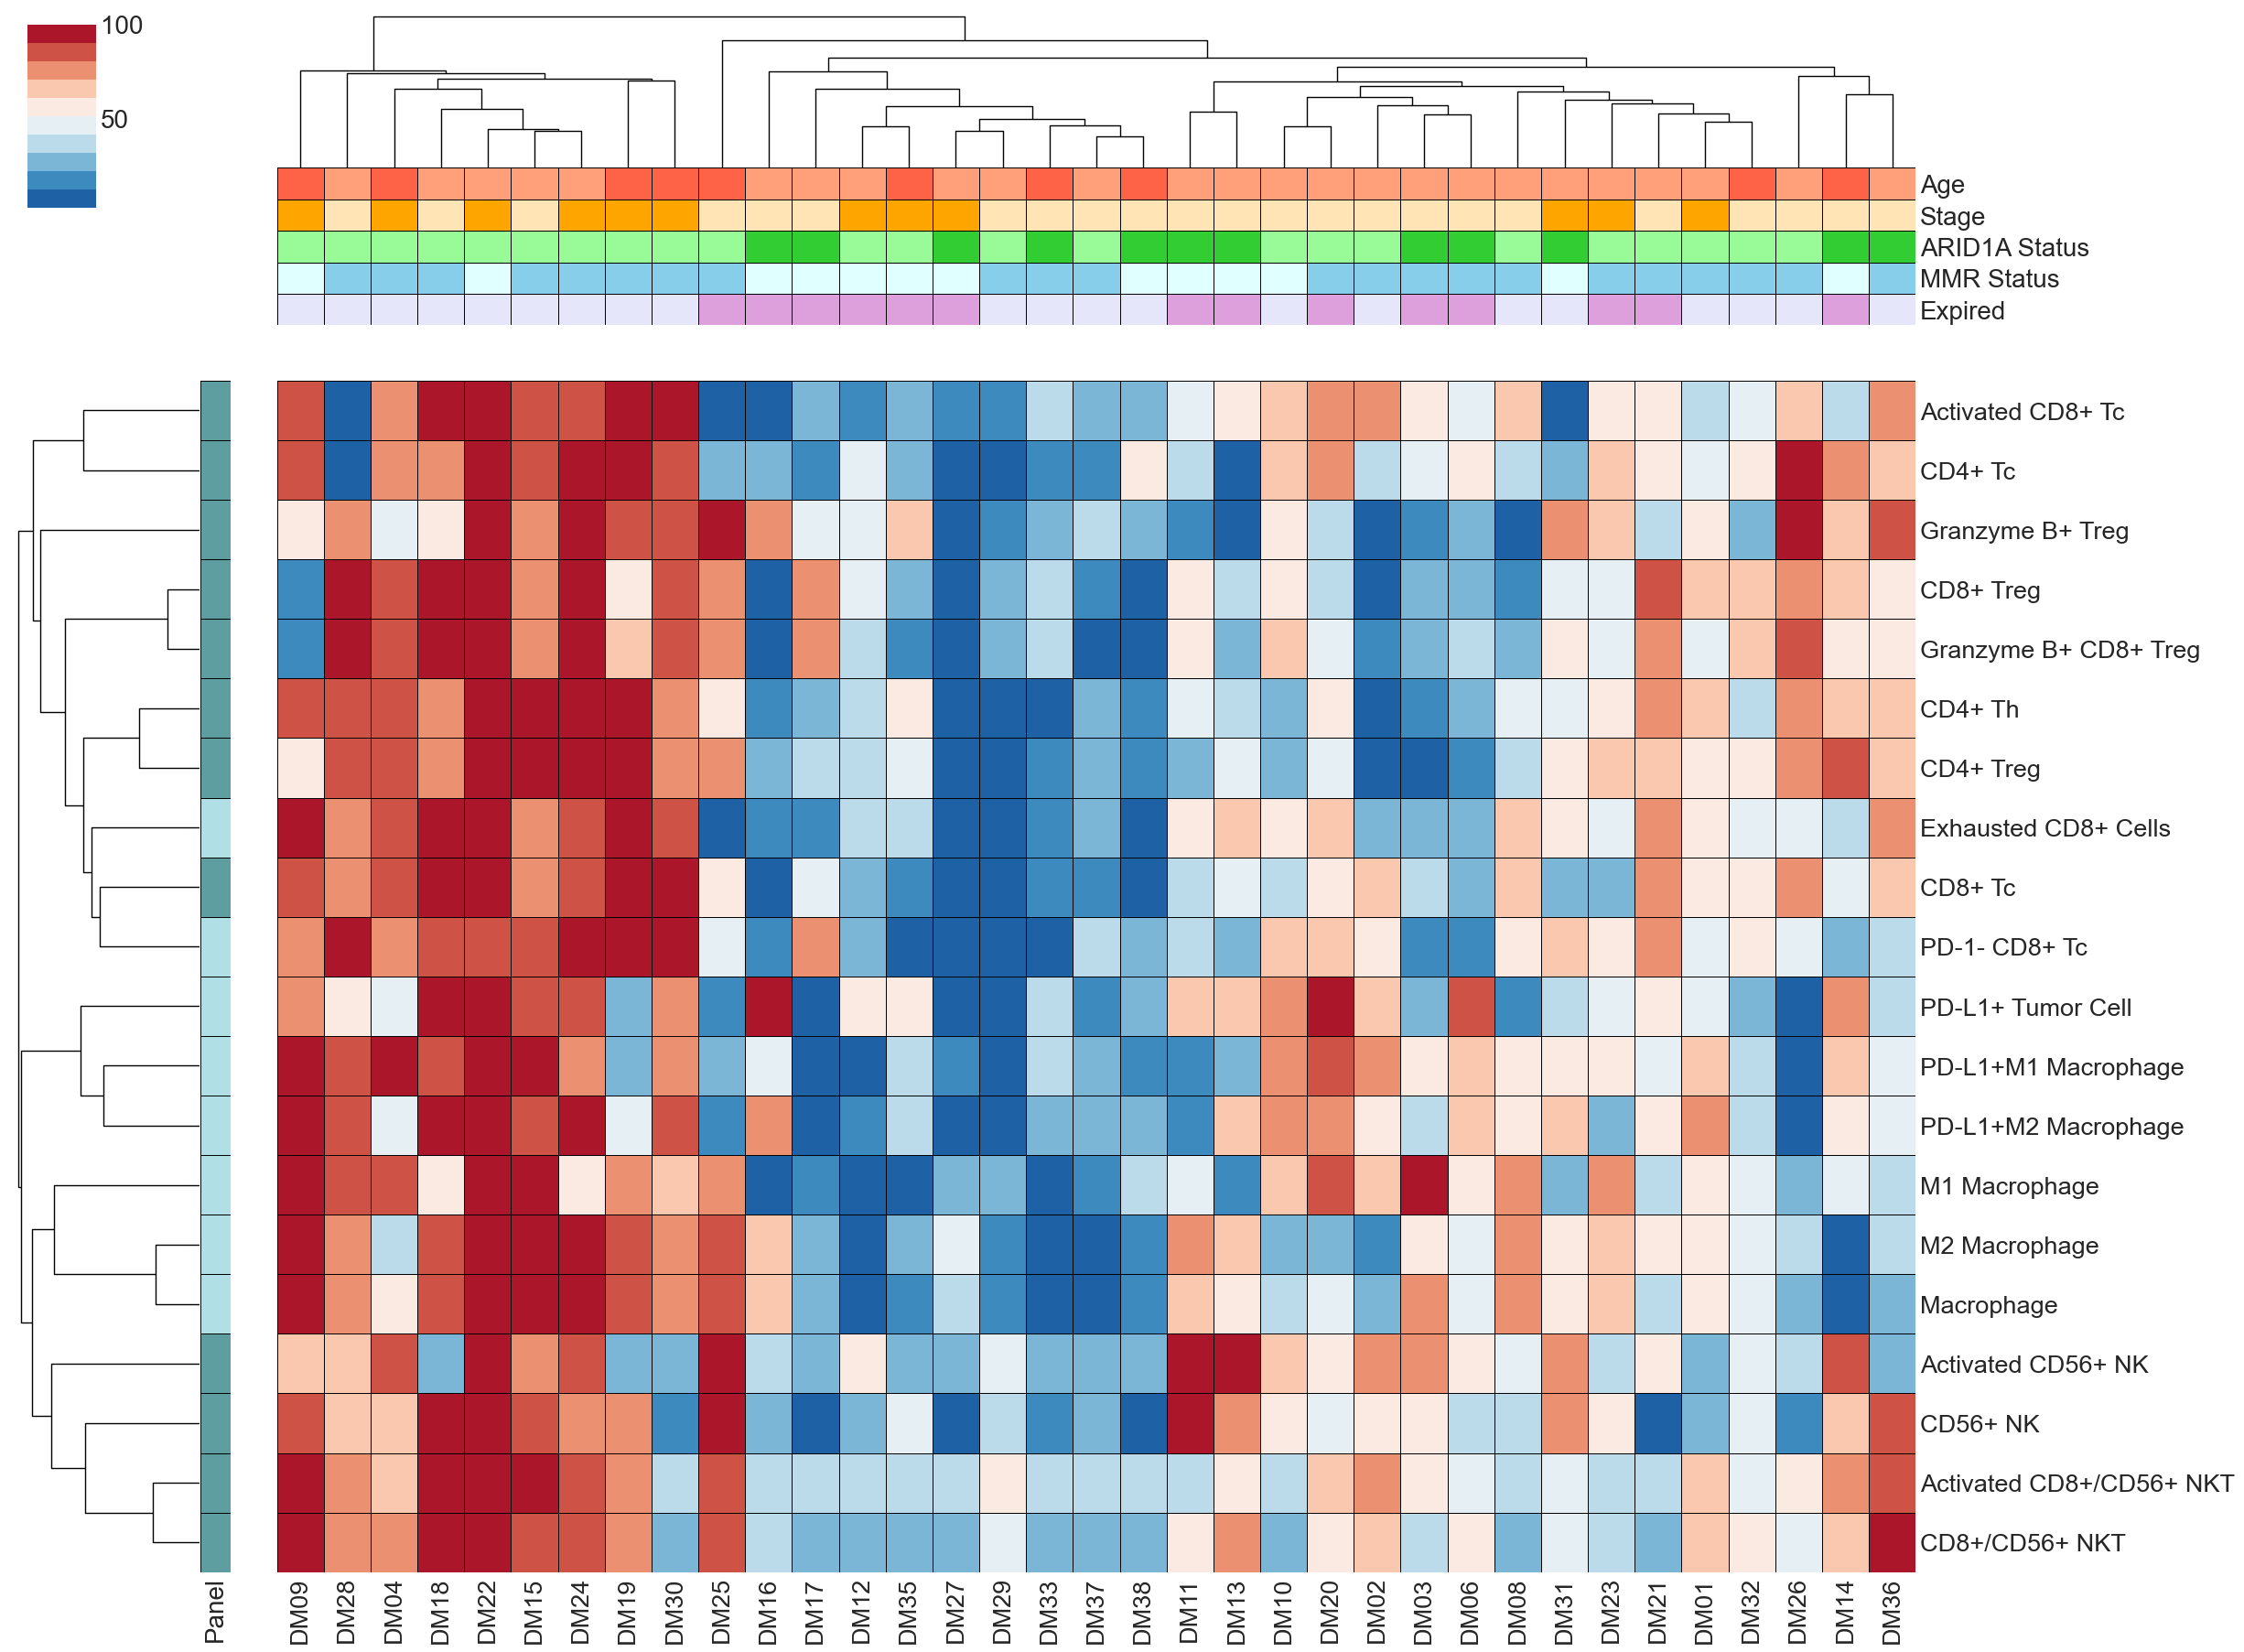

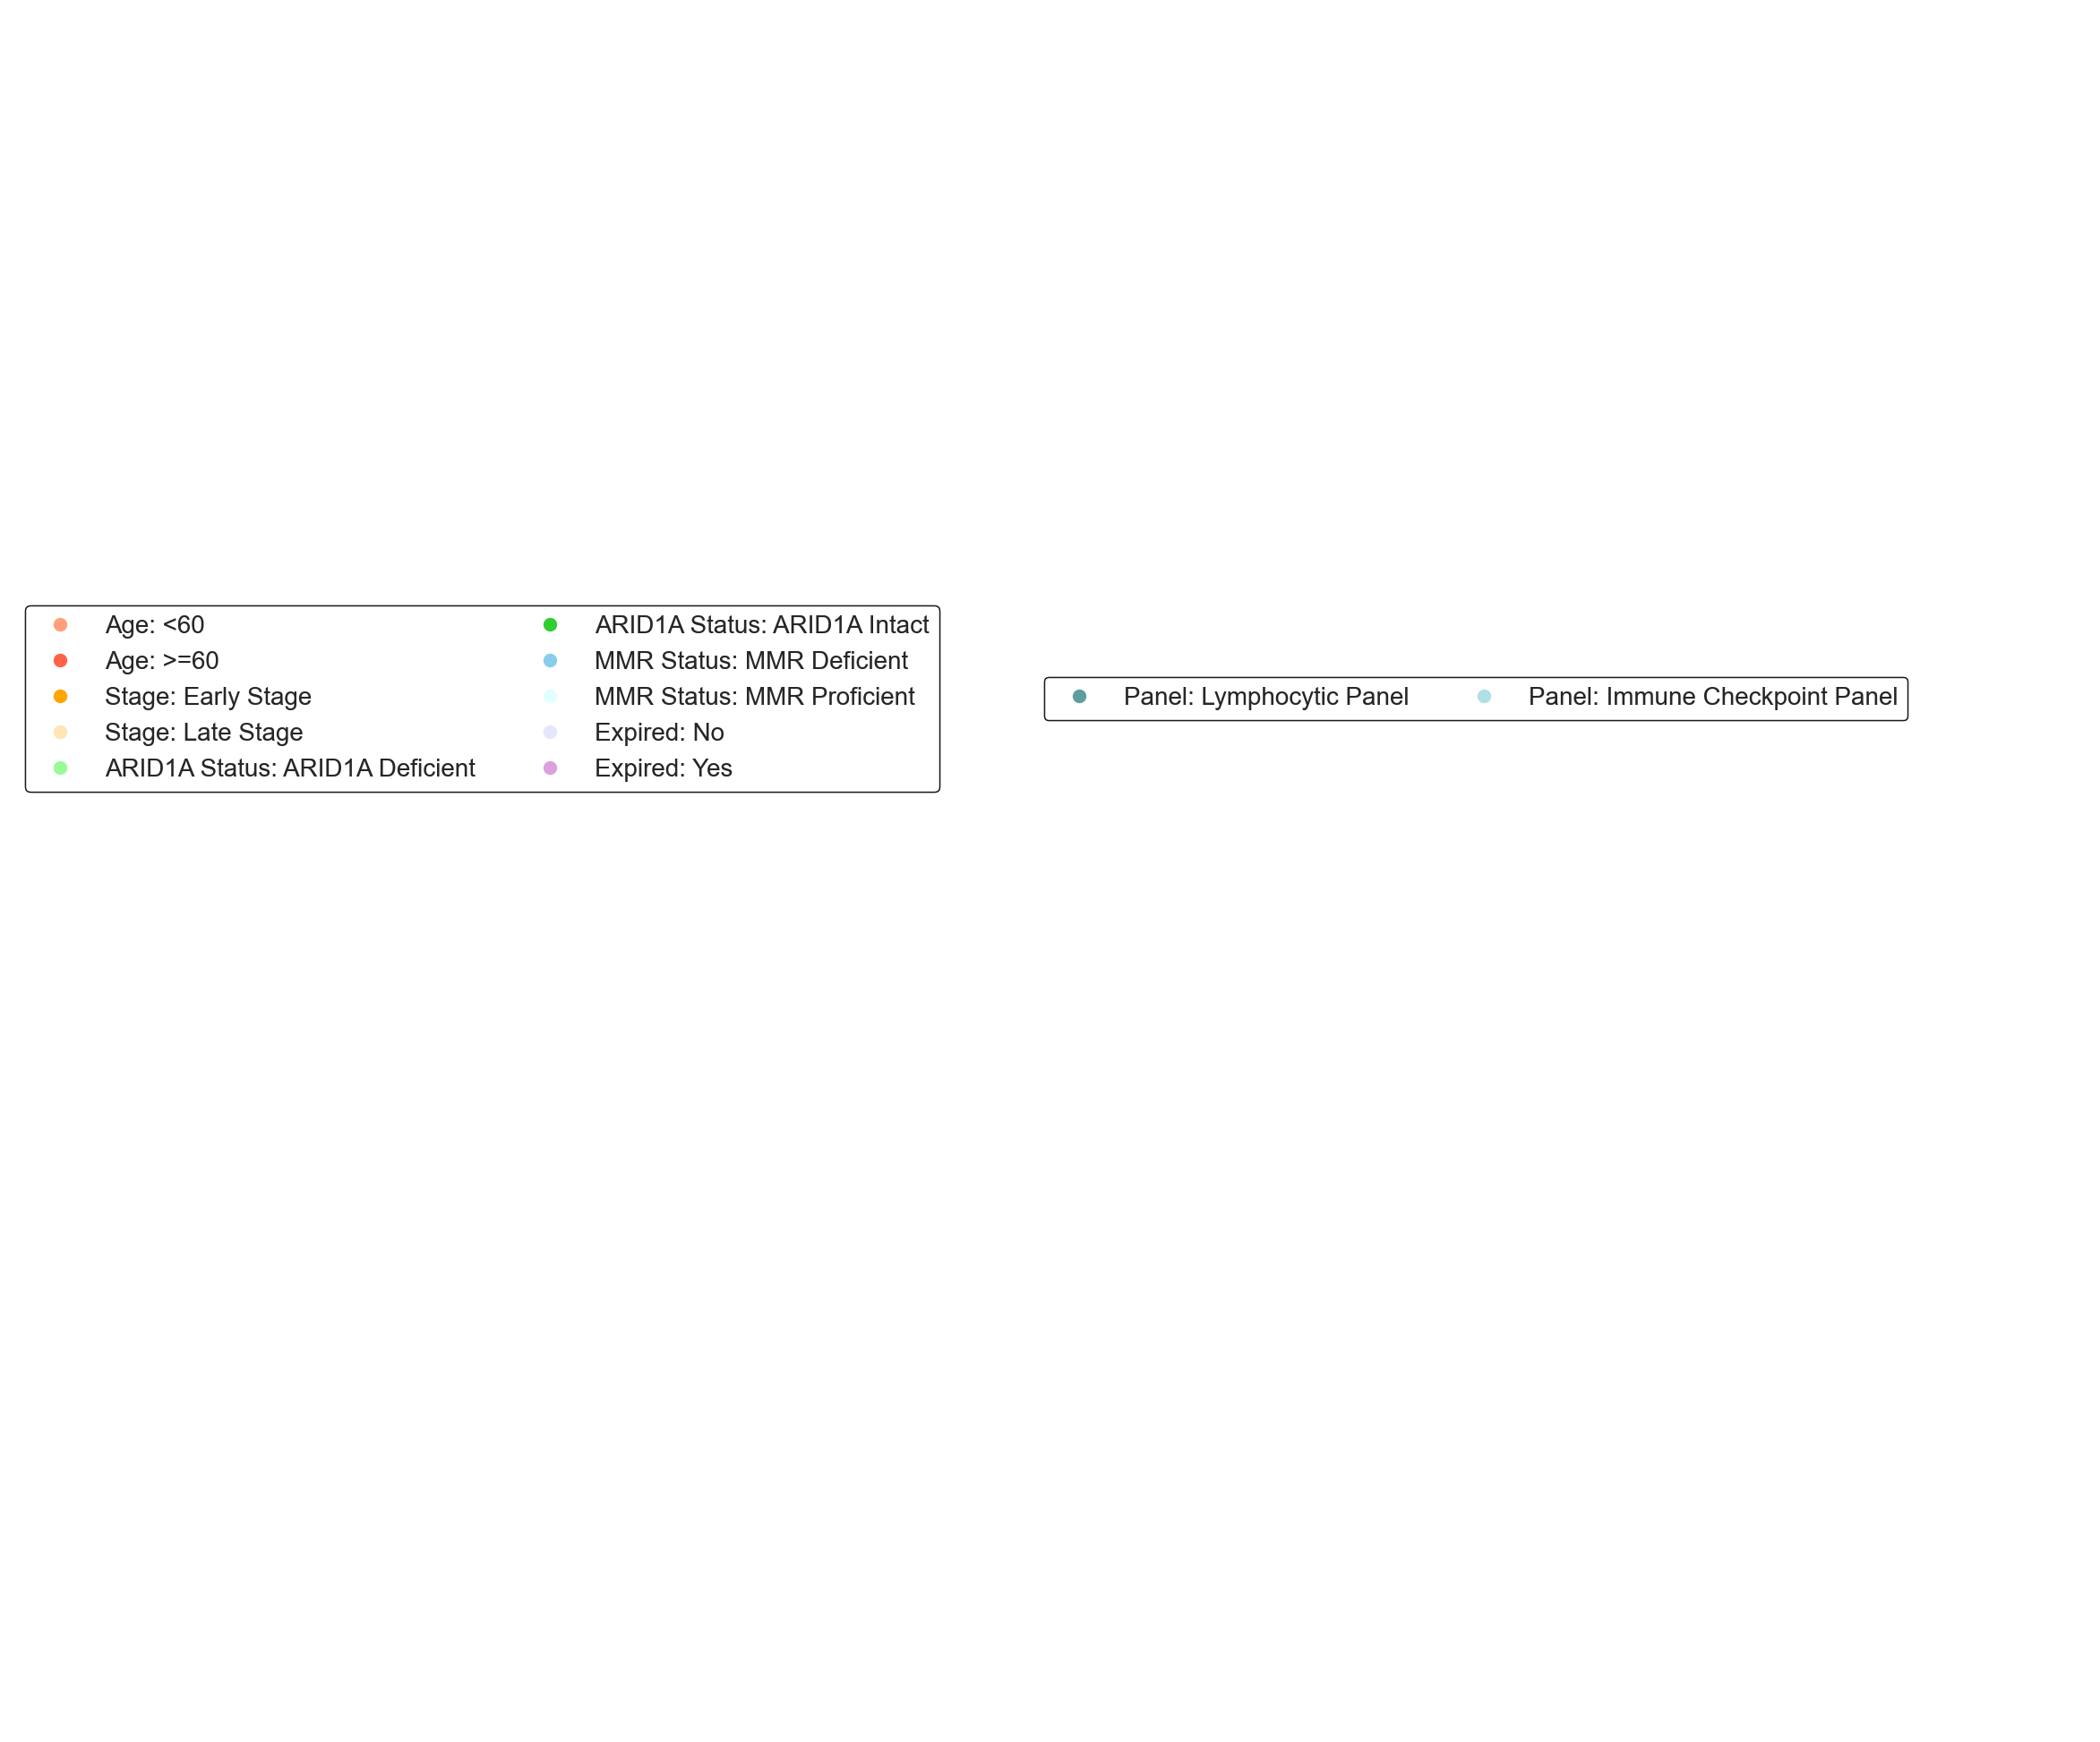

In [7]:
'''------ data_directory: Input File Directory ------'''
def main(data_directory):
    
    ''' Clustering_data_generation '''
    metric, cname1, cname2 = clustering_data_generation(data_directory)
    
    ''' Metadata '''
    #新創文件夾 row column 將row_metadata, col_metadata excel檔案放置此處
    row_metadata = pd.read_excel(r"C:\Users\S.H.Y LAB\Desktop\Simple_cluster 2024.07.03\row column\row_metadata.xlsx",index_col=0)
    col_metadata = pd.read_excel(r"C:\Users\S.H.Y LAB\Desktop\Simple_cluster 2024.07.03\row column\col_metadata.xlsx",index_col=0)
    row_colors, col_colors, row_palette, col_palette = metadata(row_metadata, col_metadata)

    ''' Choose graph type '''
    #print("What type of information do you want in your plot? Choose 0 or 1 depending on the answer")
    #print('0 for Normalized percentages with meta data and 1 for Logarithm plus Normalized with meta data')
    ch1 = int(input('Data preprocessing methods: 0 for Normalized percentages with meta data and 1 for Logarithm plus Normalized with meta data. Input selection: '))
    print("")
    
    #print("What name do you want to give your plot?  Do NOT write the file type (e.g., png, jpeg, etc)")
    ch2 = input('What name do you want to give your plot?  Do NOT write the file type (e.g., png, jpeg, etc). Write name (do not leave spaces): ')
    print("")

    save_parent_directory_normalizing = r'C:\Users\S.H.Y LAB\Desktop\Simple_cluster 2024.07.03\picture'
    save_parent_directory_sorting = r'C:\Users\S.H.Y LAB\Desktop\Simple_cluster 2024.07.03\picture'
    save_clustermap_dir_selection = f'{save_parent_directory_normalizing}/{ch2}.png'        
    save_legend_dir = f'{save_parent_directory_normalizing}/legend.png'  
    
    if ch1 == 0:
        ### === metric_normalize ===
        metric_normalize_percentage = np.zeros(metric.shape)
        metric_normalize_percentage_df = metric_percentage_calculation(metric_normalize_percentage, metric, cname1, cname2)
        plot_clustermap(metric_normalize_percentage_df, row_colors, col_colors, save_clustermap_dir_selection)
    elif ch1 == 1:
        ### === metric_log_normalize_percentage ===
        metric_log = np.log(metric+1)
        metric_log_percentage_normalize = np.zeros(metric_log.shape)
        metric_log_percentage_normalize_df = metric_percentage_calculation(metric_log_percentage_normalize, metric_log, cname1, cname2)
        # metric_log_percentage_normalize_df.to_csv("cell density after log transform and normalization.csv")
        plot_clustermap(metric_log_percentage_normalize_df, row_colors, col_colors, save_clustermap_dir_selection)
    
    plot_legend(row_palette, col_palette, save_legend_dir)


if __name__ == "__main__":
    data_directory = r'C:\Users\S.H.Y LAB\Desktop\Simple_cluster 2024.07.03'
    main(data_directory)
    #新創文件夾 new heatmap 將所有要分析的SIMPLE檔案都拉入, 文件夾位置要在DESKTOP檔案